## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Read and process dataset

In [2]:
df = pd.read_csv('thesis_dataset.csv')

In [3]:
def one_hot_encode(og_df, column, keys):
    for sat_mech in keys:
        encoder=[]
        for row in og_df[column]:
            if type(row)!=str: #for the nans (should fix soon anyway)
                encoder.append(0)
            elif sat_mech in row.split(','):
                encoder.append(1)
            else:
                encoder.append(0)
        og_df[sat_mech] = encoder

    return og_df

In [4]:
# convert evaluation values from strings to floats
df.astype({'value': 'float32'});

# convert years to strings
df.astype({'year': 'int'});
df.astype({'year': 'str'});

In [5]:
# Building the one hot encoding for the satellite data analysis

# Classifying the types of satellite mechanisms (by hand)
mechanism_dict = {
    'SAR': ['s1', 'sentinel-1', 'alos', 'terrasar-x', 'tandem-x', 'smrt', 'smtr', 'srtm', 'radarsat', 'saocom',' gaofen3', 'gf3'],
    'Optical': ['s2', 'sentinel-2', 'landsat', 'modis', 'worldview', 'quickbird', 'gaofen', 'gaofen1', 'gf1', 'gaofen2', 
                  'gf2', 'gaofen6', 'gf6' 'spot', 'geoeye', 'eo-1', 'pléiades neo', 'glass', 'rapideye', 'alos-avnir', 'planet'],
    'LiDAR': ['airborne', 'icesat', 'gedi', 'zy3', 'lidar', 'glas'],
    'Other microwave': ['smos']
      }

#building a new column based on the classifications
mechanism_column = []
not_cat = []
for item in df['data']:
    temp_mechanisms = []
    sats = item.split(',')

    for sat in sats:
        sat = sat.lower().strip()
        checker=0
        for key, value_list in mechanism_dict.items():
            if sat in value_list and key not in temp_mechanisms:
               temp_mechanisms.append(key)
            elif sat not in value_list:
                checker+=1
        if checker == 4:
            not_cat.append(sat)

    mechanism_column.append(','.join(temp_mechanisms))
df['data_mech'] = mechanism_column

# one hot encode the classifications
df = one_hot_encode(df, 'data_mech', mechanism_dict.keys())

#check if any satellites were missing in the classification
print('The satellites not classified are:')
print(set(not_cat))

The satellites not classified are:
{'spot', 'gf6', 'a1'}


In [6]:
# Building the one hot encoding for the variable analysis

# create the list of unique variables
unique_vars = []
no_nan_vars = df['variables'].dropna()
for var_str in no_nan_vars.unique():
    vars = var_str.split(',')
    for var in vars:
        if var not in unique_vars:
            unique_vars.append(var)

# one hot encode them
df = one_hot_encode(df, 'variables', unique_vars)

# check the metrics available for analysis
df['metric'].unique()

array(['r^2', 'rmse', 'bias', 'relative rmse', 'relative bias', 'rpd',
       'mae', 'me', 'relative mse', 'c-index', 'kappa', 'accuracy', 'rcv',
       'mse', 'md', 'r', 'realtive bias', 'nrmse', 'relative me',
       'relative mare', 'aic', 'cvc', 'relative mae', 'rmsd', 'mbd',
       'relative mape', 'rrmse', 'mare', 'mre', 'mape'], dtype=object)

In [7]:
# convert all metrics to mg/ha
convert_to_mgha = {'': 1,
                   'mg/ha': 1,
                   't/ha': 1,
                   'kg/m2': 10,
                   'kg/ha':1/1000,
                   't/acre': 2.47105,
                   'g/m2': 0.01,
                   'm3/hm2': 1,
                   'm3/ha': 1,
                   'mg/hm2': 1}

value_col = []
unit_col = []

for i in range(len(df)):
    if isinstance(df.iloc[i]['unit'], str):
        value_col.append(convert_to_mgha[df.iloc[i]['unit']]*df.iloc[i]['value'])
        unit_col.append('mg/ha')
    else:
        value_col.append(df.iloc[i]['value'])
        unit_col.append(df.iloc[i]['unit'])

df = df.assign(unit=unit_col)
df = df.assign(value=value_col)

In [8]:
# Chack the max of the rmse values
metric_and_values = df[['metric', 'value', 'title']]
concern = max(metric_and_values[metric_and_values['metric'] == 'rmse']['value'])
print(metric_and_values[metric_and_values['value'] == concern])

# Chack the min of the rmse values
metric_and_values = df[['metric', 'value', 'title']]
concern = min(metric_and_values[metric_and_values['metric'] == 'rmse']['value'])
print(metric_and_values[metric_and_values['value'] == concern])

     metric  value                                              title
1042   rmse  140.0  Aboveground Biomass Inversion Based on Object-...
    metric  value                                              title
628   rmse  0.466  The Utility of Sentinel-2 Spectral Data in Qua...


## Evaluate ML Methods

In [9]:
def build_metric_dict(og_df, evaluation, metric, threshold):
    #select only the category of interest and metrics of interest
    metric_and_values = og_df[['metric', evaluation, 'value']]
    values_df = metric_and_values[metric_and_values['metric'] == metric]

    #make a list of variables of interest
    unique_methods = values_df[evaluation].unique()

    #initialize the dictionary for all together
    keys = 'All Methods'+' (n='+str(len(values_df['value']))+')'
    my_dict = {keys: values_df['value'].values}

    #build dict for all other methods
    for method in unique_methods:
        temp_list = values_df[values_df[evaluation] == method]
        #only take frequently used methods
        if len(temp_list)>=threshold:
            key = method+' (n='+str(len(temp_list))+')'
            my_dict.update({key: temp_list['value'].values})

    return my_dict

In [10]:
def plot_metric_boxplots(r2,rmse):
    #initialize figure
    fig, ax = plt.subplots(1,2, figsize=(15,5))

    #plot r^2 metric
    ax[0].boxplot(r2.values())
    ax[0].set_xticklabels(r2.keys(), rotation=-35)
    ax[0].set_ylim(0,1)
    ax[0].set_ylabel('$R^2$')
    ax[0].set_title("$R^2$ per method");

    #plt rmse metric
    ax[1].boxplot(rmse.values())
    ax[1].set_xticklabels(rmse.keys(), rotation=-35)
    ax[1].set_ylabel('$RMSE$')
    ax[1].set_title("$RMSE$ per method");

    plt.show()

In [11]:
def plot_wordcloud(topic):
    r2_df = df[df['metric'] == 'r^2']
    all_vars = ''
    for i in range(len(r2_df)):
        all_vars += df[topic][i] + ' and '

    all_vars = all_vars.replace(',', ' and ')

    #create and generate a word cloud image
    wordcloud = WordCloud(stopwords=['and'], background_color='white').generate(all_vars)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

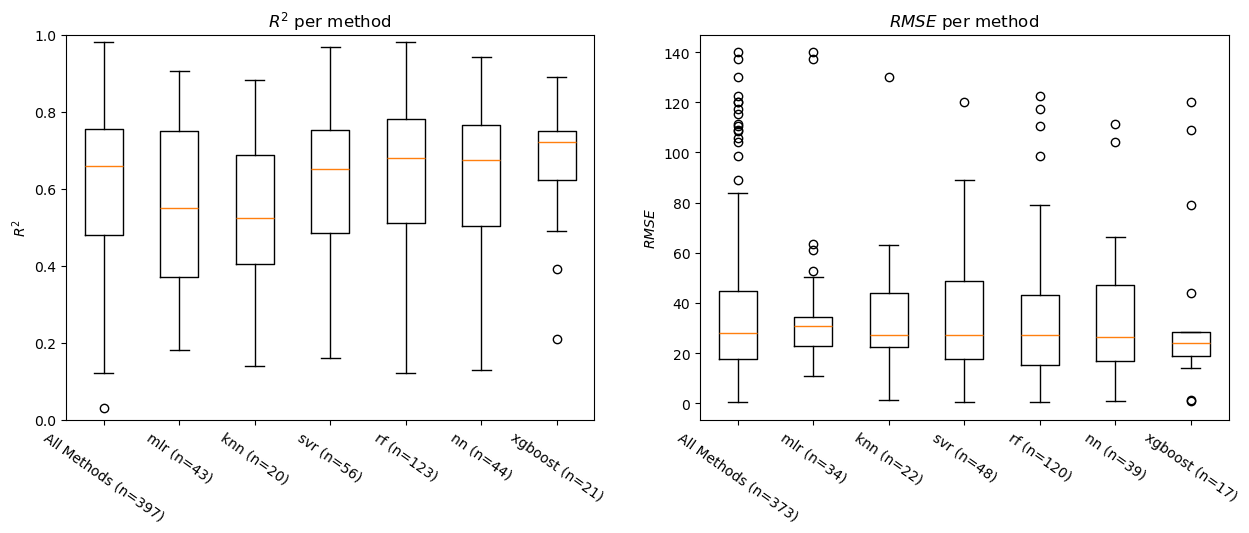

In [12]:
ml_r2_dict = build_metric_dict(df, "method", "r^2", 15)
ml_rmse_dict = build_metric_dict(df, "method", "rmse", 15) # - Need to check units and normalize

plot_metric_boxplots(ml_r2_dict, ml_rmse_dict)

## Evaluate satelittes used

categorize the satelites so I can evaluate based on type but then also individual satelittes

In [13]:
def build_encoded_dict(metric, unique_vars):
    metric_dict = {}

    metric_df = df[df['metric'] == metric]

    for var in unique_vars:
        temp_df = metric_df[metric_df[var] == 1]
        key = var+' (n='+str(len(temp_df))+')'
        metric_dict.update({key: temp_df['value'].values})

    return metric_dict

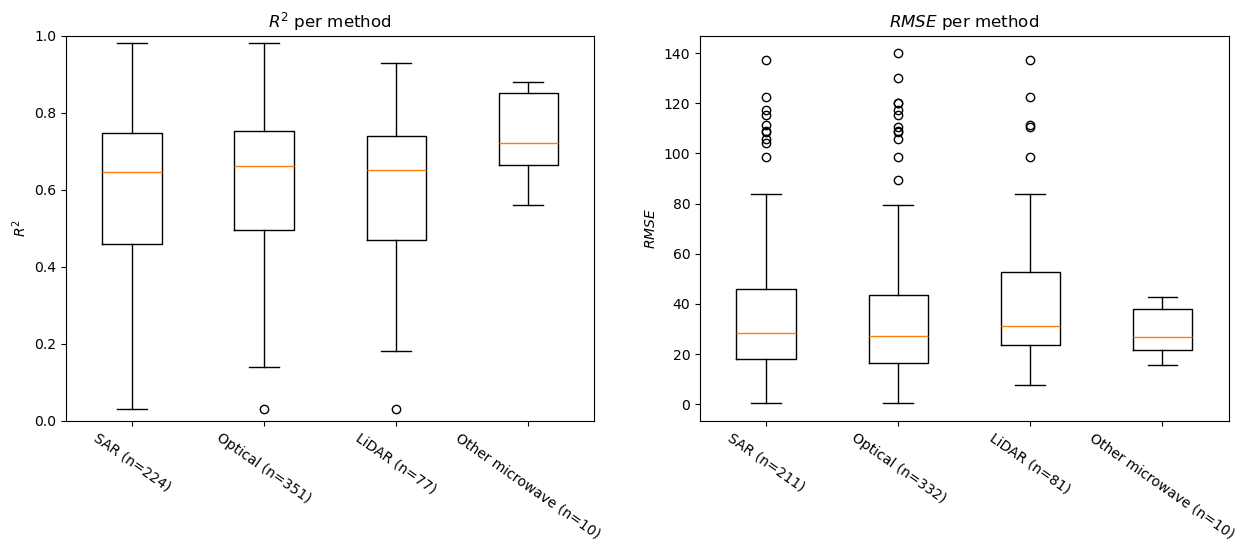

In [14]:
#make a combo bar as well? ... still needs to be done!
sat_r2_dict = build_encoded_dict('r^2', mechanism_dict.keys())
sat_rmse_dict = build_encoded_dict('rmse', mechanism_dict.keys())
plot_metric_boxplots(sat_r2_dict, sat_rmse_dict)

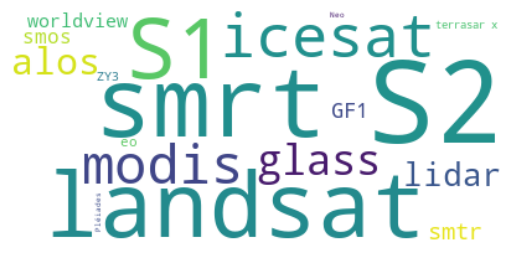

In [15]:
plot_wordcloud('data')

## Evaluate independent variables

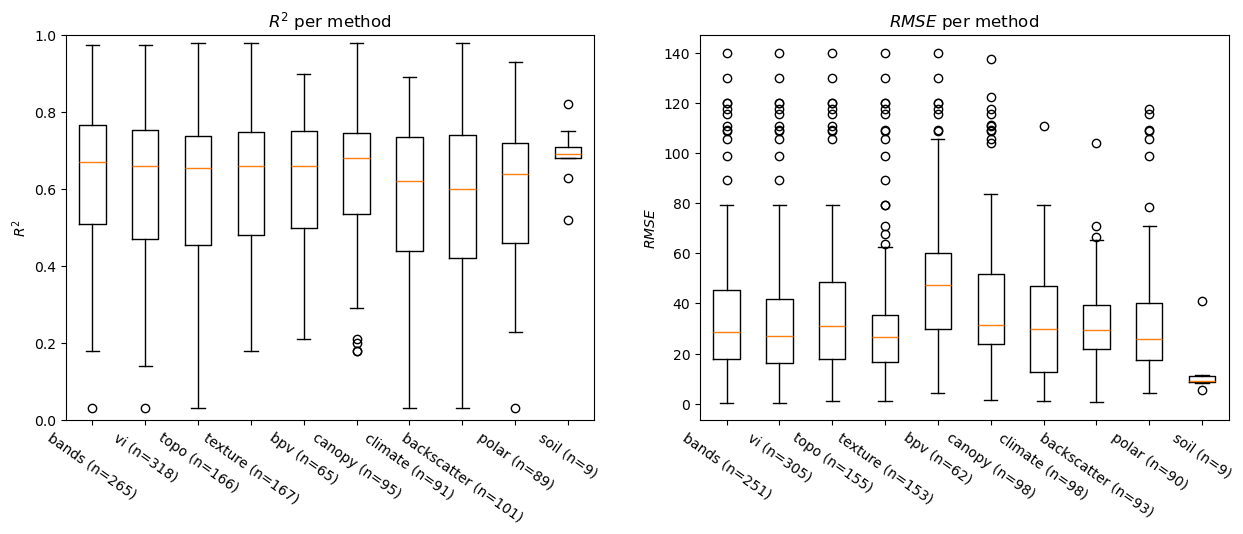

In [16]:
vars_r2_dict = build_encoded_dict('r^2', unique_vars)
vars_rmse_dict = build_encoded_dict('rmse', unique_vars)

plot_metric_boxplots(vars_r2_dict, vars_rmse_dict) # - make climate and soil seperate?

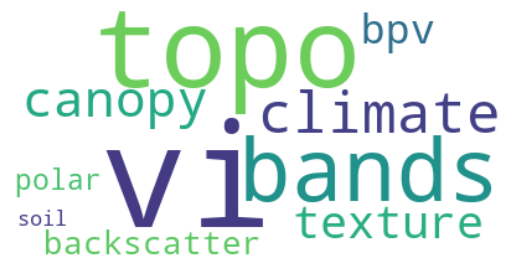

In [17]:
plot_wordcloud('variables')

## Year analysis

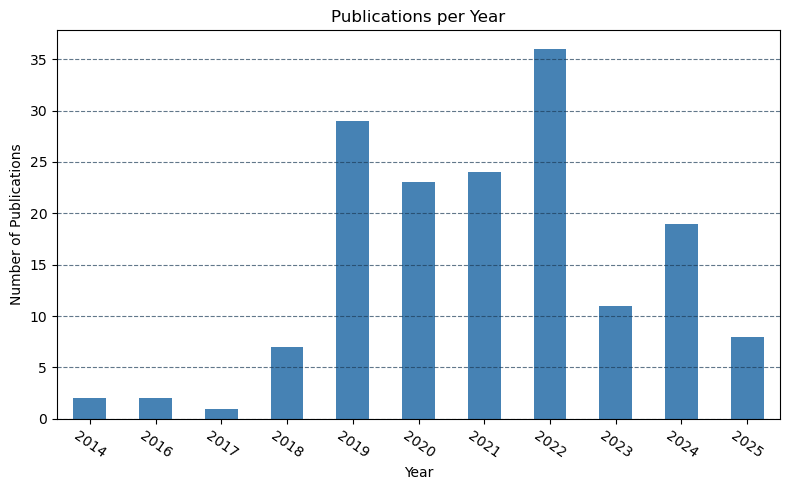

In [18]:
year_analysis =  df[['year', 'title']].drop_duplicates(['year', 'title'])

counts = year_analysis['year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color="#4682B4")

plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title('Publications per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7, color="#1E3D59")
plt.xticks(rotation=-35)

plt.tight_layout()
plt.show()

# counts.keys()

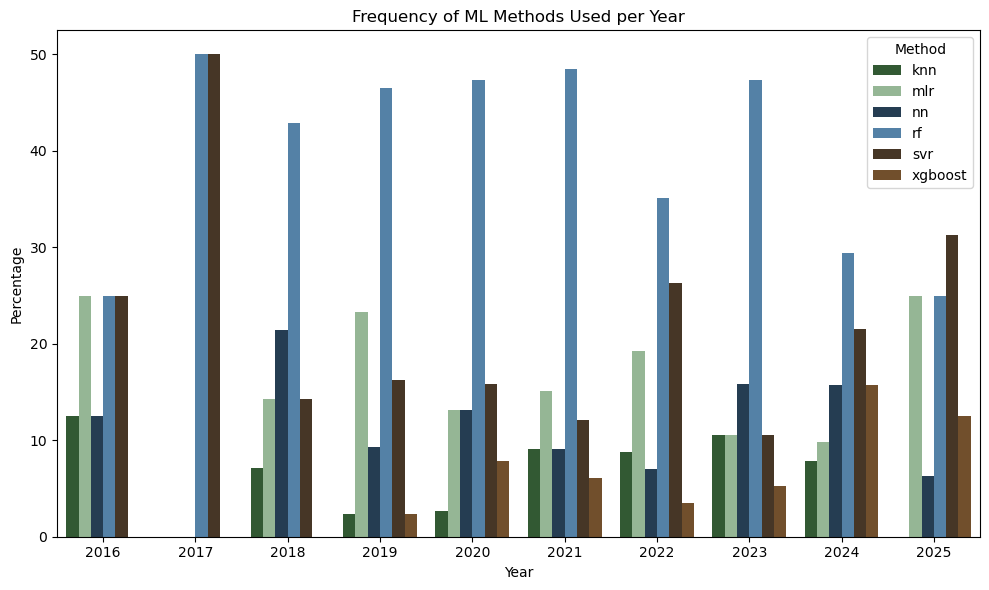

In [19]:
# Plot change of ml method overtime



# Figure out which methods to include (n>15)
common_methods = []
for method in list(ml_r2_dict.keys()):
    name = method.split()[0]
    common_methods.append(name)

# Count the frequency of each method per year
data = df[df['method'].isin(common_methods)][['method', 'year', 'title']].drop_duplicates()
data = data[data['year'] != 2014]
method_counts = data.groupby(['method', 'year']).size().reset_index(name='count')

# Step 3: Calculate total per year and compute percentage
totals = method_counts.groupby('year')['count'].transform('sum')
method_counts['percentage'] = method_counts['count'] / totals * 100

# Plotting
custom_palette = [
    "#2C5F2D",  # deep forest green
    "#8FBC8F",  # sage green (more vibrant, still earthy)
    "#1E3D59",  # deep navy for lake/deep water
    "#4682B4",  # steel blue (cooler than sky blue, more defined)
    "#4B3621",  # dark brown (carbon/peat)
    "#7C4F20"  # burnt sienna / dry soil
]

plt.figure(figsize=(10, 6))
sns.barplot(data=method_counts, x='year', y='percentage', hue='method', palette=custom_palette)

plt.title('Frequency of ML Methods Used per Year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Method')
plt.tight_layout()
plt.show()

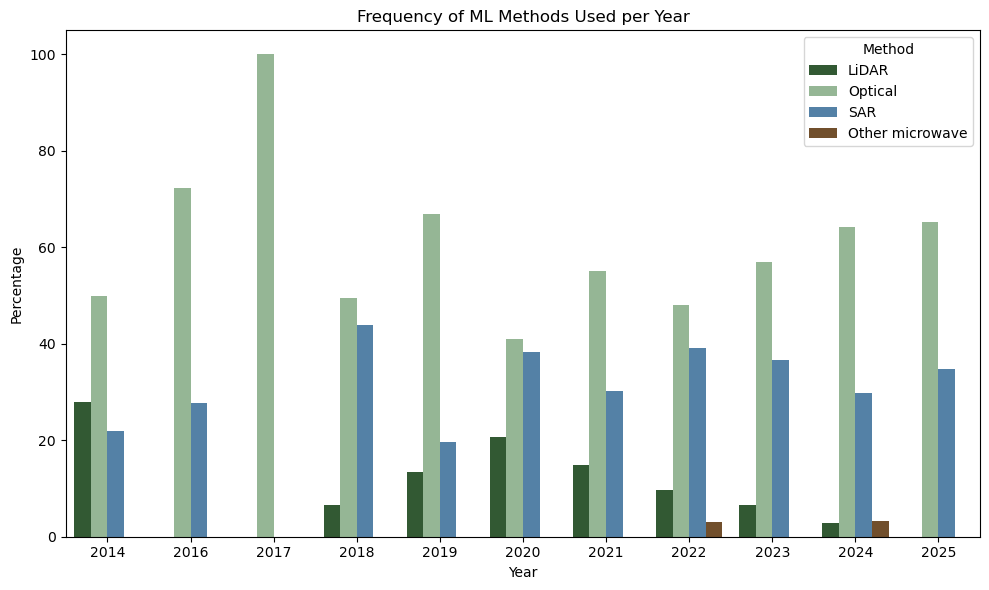

In [20]:
# Plot change of data over time

melted = df.melt(id_vars=['year', 'title'],
                   value_vars=['SAR', 'Optical', 'LiDAR', 'Other microwave'],
                   var_name='SensorType',
                   value_name='Used')

# Step 2: Filter rows where sensor was used (value = 1)
used_sensors = melted[melted['Used'] == 1]

# Step 3: Count occurrences per Year and SensorType
counts = used_sensors.groupby(['year', 'SensorType']).size().reset_index(name='count')

# Step 4: Calculate percentages per year
counts['percentage'] = counts.groupby('year')['count'].transform(lambda x: x / x.sum() * 100)

# Plotting
custom_palette = [
    "#2C5F2D",  # deep forest green
    "#8FBC8F",  # sage green (more vibrant, still earthy)
    "#4682B4",  # steel blue (cooler than sky blue, more defined)
    "#7C4F20"  # burnt sienna / dry soil
]

plt.figure(figsize=(10, 6))
sns.barplot(data=counts, x='year', y='percentage', hue='SensorType', palette=custom_palette)

plt.title('Frequency of ML Methods Used per Year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Method')
plt.tight_layout()
plt.show()